# <h1><b><I> General Setup

## Imports and general setup

In [1]:
import os, sys, time
from tqdm import tqdm
sys.path.append("gammabayes/BFCalc/")
sys.path.append("gammabayes")

# from gammabayes.BFCalc.createspectragrids import singlechannel_diffflux, getspectrafunc, darkmatterdoubleinput, energymassinputspectralfunc
from gammabayes.likelihoods.instrument_response_funcs import log_bkg_CCR_dist, log_edisp, log_psf, single_loglikelihood
from scipy import interpolate, special, integrate
from gammabayes.utils.event_axes import log10eaxistrue, longitudeaxistrue, latitudeaxistrue, log10eaxis, longitudeaxis, latitudeaxis
# from gammabayes.utils.utils import inverse_transform_sampling
from gammabayes.hyper_inference.hyperparameter_likelihood import hyperparameter_likelihood
from gammabayes.priors.prior import discrete_logprior
from gammabayes.likelihoods.likelihood import discrete_loglikelihood
from gammabayes.dark_matter.SS_DM_Constructor import SS_DM_dist


import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
from astropy import units as u
from scipy import special,stats
from scipy.integrate import simps
from matplotlib import cm
from tqdm.autonotebook import tqdm as notebook_tqdm

import functools, random
from multiprocessing import Pool, freeze_support
import multiprocessing
import pandas as pd

random.seed(1)


/Users/lpin0002/anaconda3/envs/please/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
0.47027777777777774*(8/16)*(1e7/1e3)*(1/100)

23.513888888888886

In [3]:
astrophysicalbackground = np.load("gammabayes/package_data/unnormalised_astrophysicalbackground.npy")
psfnormalisationvalues = np.load("gammabayes/package_data/psfnormalisation.npy")
edispnormalisationvalues = np.load("gammabayes/package_data/edispnormalisation.npy")


In [4]:
log10emeshtrue, lonmeshtrue, latmeshtrue = np.meshgrid(log10eaxistrue, longitudeaxistrue, latitudeaxistrue, indexing='ij')
lonmeshrecon, latmeshrecon = np.meshgrid(longitudeaxis, latitudeaxis, indexing='ij')

logjacobtrue = np.meshgrid(np.log(10**log10eaxistrue), longitudeaxistrue, latitudeaxistrue, indexing='ij')[0]


print(lonmeshtrue.shape, lonmeshrecon.shape)

(301, 35, 30) (18, 15)


## Script Parameter Setup

In [5]:
numberoftruevaluesamples = int(1e3)
Nsamples=numberoftruevaluesamples
sigfraction             = 0.2
astrofraction           = 0.4
ccrfraction             = 0.4
nsig                    = int(round(sigfraction*Nsamples))
nastro                  = int(round(astrofraction*Nsamples))
nccr                    = int(round(ccrfraction*Nsamples))

truesigfrac          = nsig/(nastro+nsig+nccr)
trueastrofrac        = nastro/(nastro+nsig+nccr)
trueccrfrac          = nccr/(nastro+nsig+nccr)
numcores            = 8
truelogmass         = 0.5

startertimer = time.perf_counter()
print(startertimer)

2.818282792


# <h1><b>Simulation

## Setup

### Astro Background setup

In [6]:
unnormed_log_astrobkgpriorvalues = np.log(astrophysicalbackground)


log_astrobkgpriorvalues = unnormed_log_astrobkgpriorvalues - special.logsumexp(unnormed_log_astrobkgpriorvalues+logjacobtrue)

log_astrobkgpriorvalues.shape




log_bkgastro = interpolate.RegularGridInterpolator((log10eaxistrue, longitudeaxistrue, latitudeaxistrue), np.exp(log_astrobkgpriorvalues))
log_astro_bkgfunc = lambda logenergy, longitude, latitude: np.log(log_bkgastro((logenergy, longitude, latitude)))


astro_bkg_prior = discrete_logprior(logfunction=log_astro_bkgfunc, name='Astrophysical Background Prior',
                               axes=(log10eaxistrue, longitudeaxistrue, latitudeaxistrue,), 
                               axes_names=['energy', 'lon', 'lat'], logjacob=logjacobtrue)

In [7]:
ccr_bkg_prior = discrete_logprior(logfunction=log_bkg_CCR_dist, name='CCR Mis-identification Background Prior',
                               axes=(log10eaxistrue, longitudeaxistrue, latitudeaxistrue,), 
                               axes_names=['energy', 'lon', 'lat'], logjacob=logjacobtrue)

### Signal Setup

In [8]:
SS_DM_dist_instance= SS_DM_dist(longitudeaxistrue, latitudeaxistrue)
logDMpriorfunc = SS_DM_dist_instance.func_setup()

In [9]:
DM_prior = discrete_logprior(logfunction=logDMpriorfunc, name='Scalar Singlet Dark Matter Prior',
                               axes=(log10eaxistrue, longitudeaxistrue, latitudeaxistrue,), axes_names=['energy', 'lon', 'lat'],
                               default_hyperparameter_values=(truelogmass,), hyperparameter_names=['mass'], logjacob=logjacobtrue)
DM_prior

(0.5,)


discrete log prior class
----------------------------
name = Scalar Singlet Dark Matter Prior
logfunction type is <function SS_DM_dist.func_setup.<locals>.DM_signal_dist at 0x7fc3e4ea3af0>
input units of None
over axes ['energy', 'lon', 'lat']
with hyperparameter(s) ['mass']

## True Value Simulation

In [10]:
if truesigfrac!=0.0:
    siglogevals,siglonvals,siglatvals  = DM_prior.sample(nsig)
else:
    siglogevals = np.asarray([])
    siglonvals = np.asarray([])
    siglatvals = np.asarray([])

if trueastrofrac!=0.0:
    astrologevals,astrolonvals,astrolatvals  = astro_bkg_prior.sample(nastro)
else:
    astrologevals = np.asarray([])
    astrolonvals = np.asarray([])
    astrolatvals = np.asarray([])

if trueccrfrac!=0.0:
    ccrlogevals,ccrlonvals,ccrlatvals  = ccr_bkg_prior.sample(nccr)
else:
    ccrlogevals = np.asarray([])
    ccrlonvals = np.asarray([])
    ccrlatvals = np.asarray([])

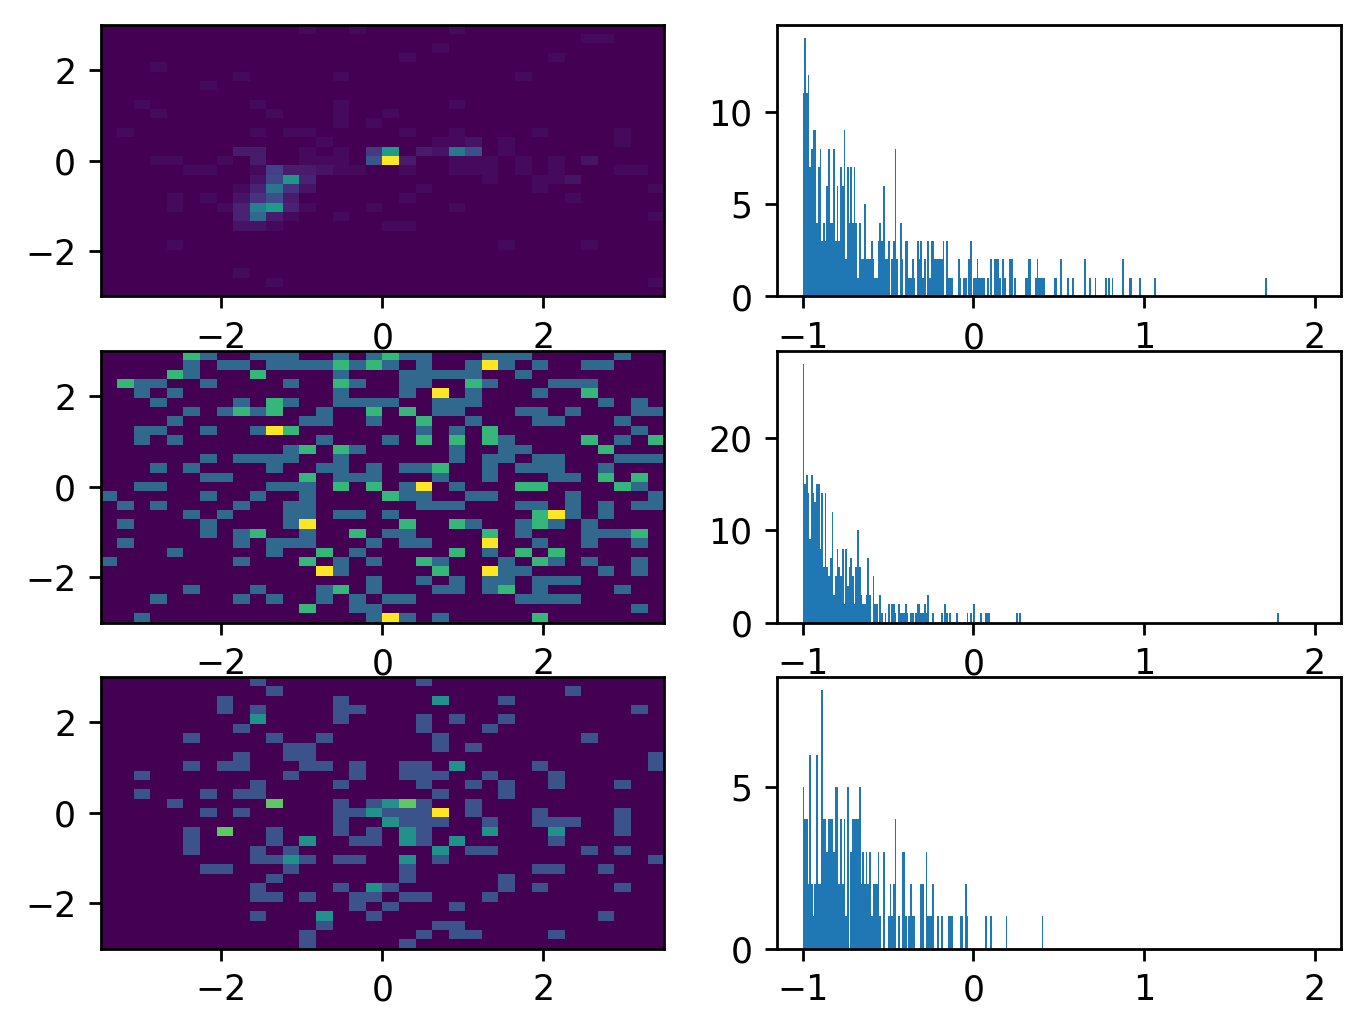

In [11]:
plt.figure(dpi=250)
plt.subplot(321)
plt.hist2d(astrolonvals,astrolatvals, bins=(longitudeaxistrue, latitudeaxistrue))

plt.subplot(322)
plt.hist(astrologevals, bins=log10eaxistrue)

plt.subplot(323)
plt.hist2d(ccrlonvals,ccrlatvals, bins=(longitudeaxistrue, latitudeaxistrue))

plt.subplot(324)
plt.hist(ccrlogevals, bins=log10eaxistrue)

plt.subplot(325)
plt.hist2d(siglonvals,siglatvals, bins=(longitudeaxistrue, latitudeaxistrue))

plt.subplot(326)
plt.hist(siglogevals, bins=log10eaxistrue)
plt.show()

## Reconstructed Value Simulation

In [12]:
logjacob = np.meshgrid(np.log(10**log10eaxis), longitudeaxis, latitudeaxis, indexing='ij')[0]

In [13]:
logjacob = np.log(10**log10eaxis)
edisp_like = discrete_loglikelihood(logfunction=log_edisp, 
                                    axes=(log10eaxis,), axes_names='log10E recon',
                                    name='energy dispersion',
                                    dependent_axes=(log10eaxistrue, longitudeaxistrue, latitudeaxistrue,), logjacob=logjacob,
                                    dependent_axes_names = ['log10E true', 'lon', 'lat'])

Number of input dimensions 1


In [14]:
psf_like = discrete_loglikelihood(logfunction=log_psf, 
                                    axes=(longitudeaxis, latitudeaxis), axes_names=['longitude recon', 'latitude recon'],
                                    name='point spread function ',
                                    dependent_axes=(log10eaxistrue, longitudeaxistrue, latitudeaxistrue,),
                                    dependent_axes_names = ['log10E true', 'lon', 'lat'])
psf_like

Number of input dimensions 2


discrete log likelihood class
---------------------------------
name = point spread function 
logfunction type is <function log_psf at 0x7fc3e3e5f040>
input units of None
over axes ['longitude recon', 'latitude recon']
with dependent axes ['log10E true', 'lon', 'lat']

### Signal

In [15]:
signal_lon_measured = []
signal_lat_measured = []
if truesigfrac!=0.0:
    signal_log10e_measured = [np.squeeze(edisp_like.sample((logeval,*coord,), numsamples=1)) for logeval,coord  in notebook_tqdm(zip(siglogevals, np.array([siglonvals, siglatvals]).T), total=nsig)]
    sig_lonlat_psf_samples =  [psf_like.sample((logeval,*coord,), 1).tolist() for logeval,coord  in notebook_tqdm(zip(siglogevals, np.array([siglonvals, siglatvals]).T), total=nsig)]
    
    for sig_lonlat_psf_sample in sig_lonlat_psf_samples:
        signal_lon_measured.append(sig_lonlat_psf_sample[0])
        signal_lat_measured.append(sig_lonlat_psf_sample[1])
else:
    signal_log10e_measured = np.asarray([])

100%|██████████| 200/200 [00:01<00:00, 170.37it/s]


### Background

In [16]:
astro_lon_measured = []
astro_lat_measured = []
if trueastrofrac!=0.0:
    astro_log10e_measured = [np.squeeze(edisp_like.sample((logeval,*coord,), numsamples=1)) for logeval,coord  in notebook_tqdm(zip(astrologevals, np.array([astrolonvals, astrolatvals]).T), total=nastro)]
    astro_lonlat_psf_samples =  [psf_like.sample((logeval,*coord,), 1).tolist() for logeval,coord  in notebook_tqdm(zip(astrologevals, np.array([astrolonvals, astrolatvals]).T), total=nastro)]
    
    for astro_lonlat_psf_sample in astro_lonlat_psf_samples:
        astro_lon_measured.append(astro_lonlat_psf_sample[0])
        astro_lat_measured.append(astro_lonlat_psf_sample[1])
else:
    astro_log10e_measured = np.asarray([])

100%|██████████| 400/400 [00:02<00:00, 171.35it/s]


In [17]:
ccr_lon_measured = []
ccr_lat_measured = []
if trueccrfrac!=0.0:
    ccr_log10e_measured = [np.squeeze(edisp_like.sample((logeval,*coord,), numsamples=1)) for logeval,coord  in notebook_tqdm(zip(ccrlogevals, np.array([ccrlonvals, ccrlatvals]).T), total=nccr)]
    ccr_lonlat_psf_samples =  [psf_like.sample((logeval,*coord,), 1).tolist() for logeval,coord  in notebook_tqdm(zip(ccrlogevals, np.array([ccrlonvals, ccrlatvals]).T), total=nccr)]
    
    for ccr_lonlat_psf_sample in ccr_lonlat_psf_samples:
        ccr_lon_measured.append(ccr_lonlat_psf_sample[0])
        ccr_lat_measured.append(ccr_lonlat_psf_sample[1])
else:
    ccr_log10e_measured = np.asarray([])

100%|██████████| 400/400 [00:02<00:00, 170.78it/s]


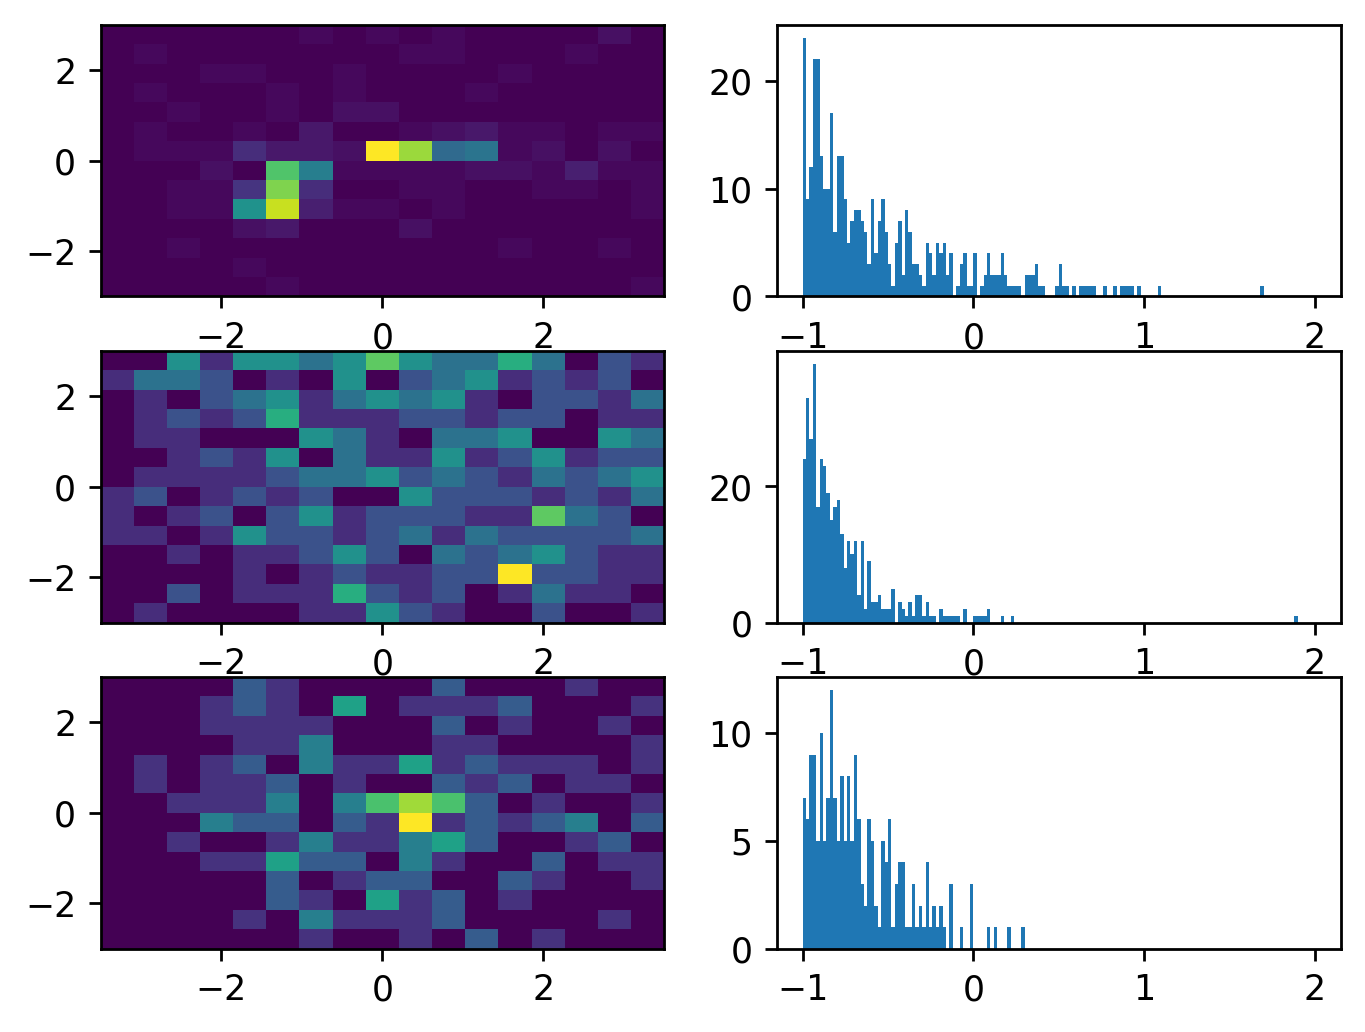

In [18]:
plt.figure(dpi=250)
plt.subplot(321)
plt.hist2d(astro_lon_measured, astro_lat_measured, bins=(longitudeaxis, latitudeaxis))

plt.subplot(322)
plt.hist(astro_log10e_measured, bins=log10eaxis)

plt.subplot(323)
plt.hist2d(ccr_lon_measured, ccr_lat_measured, bins=(longitudeaxis, latitudeaxis))

plt.subplot(324)
plt.hist(ccr_log10e_measured, bins=log10eaxis)

plt.subplot(325)
plt.hist2d(signal_lon_measured,signal_lat_measured, bins=(longitudeaxis, latitudeaxis))

plt.subplot(326)
plt.hist(signal_log10e_measured, bins=log10eaxis)
plt.show()

## Final simulation output

In [19]:


try:
    measured_log10e = list(signal_log10e_measured)+list(astro_log10e_measured)+list(ccr_log10e_measured)
    measured_lon = list(signal_lon_measured)+list(astro_lon_measured)+list(ccr_lon_measured)
    measured_lat = list(signal_lat_measured)+list(astro_lat_measured)+list(ccr_lat_measured)
    
except:
    print('what')

# <h1><b>Analysis

## Marginalisation

In [20]:
nbinslogmass=51

if nsig is None:
    nsig = len(list(measured_log10e))

logmasswindowwidth      = 20/np.sqrt(nsig)

logmasslowerbound       = truelogmass-logmasswindowwidth
logmassupperbound       = truelogmass+logmasswindowwidth

# if 1:
if logmasslowerbound<log10eaxis[0]:
    logmasslowerbound = log10eaxis[0]
# if 1:
if logmassupperbound>2:
    logmassupperbound = 2


logmassrange            = np.linspace(logmasslowerbound, logmassupperbound, nbinslogmass) 

In [21]:
hyperparameter_likelihood_instance = hyperparameter_likelihood(priors=(DM_prior, astro_bkg_prior, ccr_bkg_prior,), likelihood=single_loglikelihood, 
                                                               dependent_axes=(log10eaxistrue,  longitudeaxistrue, latitudeaxistrue), dependent_logjacob=logjacobtrue,
                                                               hyperparameter_axes = ((logmassrange,), (None,), (None,)), numcores=numcores, likelihoodnormalisation = psfnormalisationvalues+edispnormalisationvalues)

measured_log10e = [float(measured_log10e_val) for measured_log10e_val in measured_log10e]
margresults = hyperparameter_likelihood_instance.nuisance_log_marginalisation(axisvals= (measured_log10e, measured_lon, measured_lat))

Setting up prior matrices: 100%|██████████| 3/3 [00:38<00:00, 12.81s/it]
Performing parallelized direct event marginalisation: 100%|██████████| 1000/1000 [00:00<00:00, 1562706.41it/s]
/Users/lpin0002/Desktop/temporaryfolder/GammaBayes/gammabayes/likelihoods/instrument_response_funcs.py:53: RuntimeWarning: divide by zero encountered in log
  output = np.log(psffull.evaluate(energy_true=10**logetrue*u.TeV,
/Users/lpin0002/Desktop/temporaryfolder/GammaBayes/gammabayes/likelihoods/instrument_response_funcs.py:57: RuntimeWarning: divide by zero encountered in log
  output+=np.log(edispfull.evaluate(energy_true=10**logetrue*u.TeV,


In [22]:
margresultsarray = np.array(margresults)
sigmargresults = np.squeeze(np.vstack(margresultsarray[:,0])).T
astromargresults = np.squeeze(np.vstack(margresultsarray[:,1]))
ccrmargresults = np.squeeze(np.vstack(margresultsarray[:,2]))
sigmargresults.shape

(51, 1000)

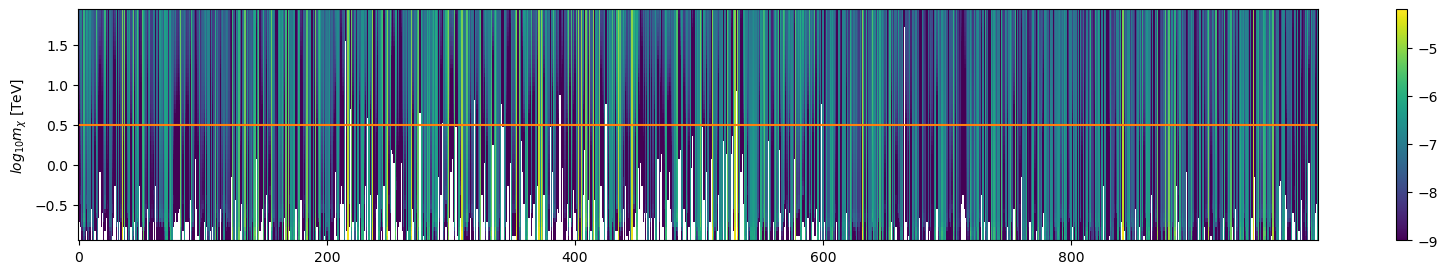

In [23]:
fig, ax = plt.subplots(figsize=(20,3))
plt.pcolormesh(*np.meshgrid(list(range(Nsamples)), logmassrange, indexing='ij'), 
               sigmargresults.T-special.logsumexp(sigmargresults, axis=1), 
               cmap='viridis', vmin=-9)
plt.ylabel(r'$log_{10}m_\chi$ [TeV]')
plt.axhline(truelogmass, c='tab:orange')
plt.colorbar()
plt.show()

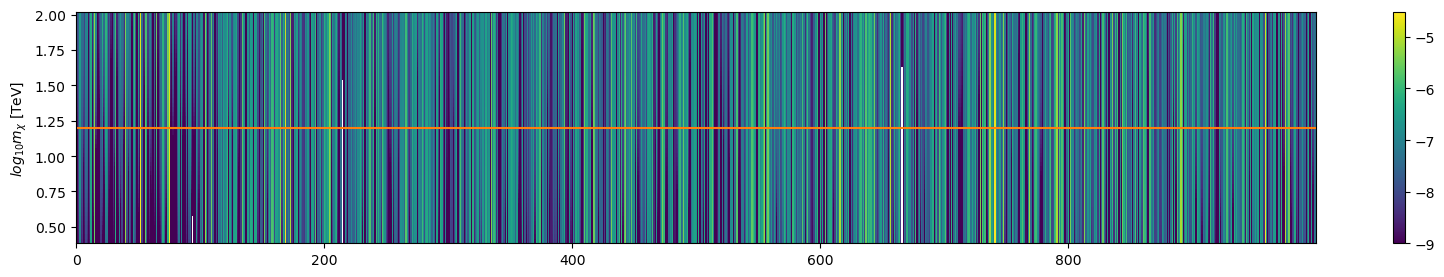

## Calculating posterior

In [24]:
nbinslambda            = 151
lambdawindowwidth      = 9/np.sqrt(Nsamples)
sigfracrange = np.linspace(0,0.5,61)
astrofracrange = np.linspace(0,0.5,51)
mixtureaxes = sigfracrange, astrofracrange
    
new_log_posterior = hyperparameter_likelihood_instance.create_mixture_log_hyper_likelihood(
    mixture_axes=(*mixtureaxes,), log_margresults=margresultsarray)

new_log_posterior = new_log_posterior - special.logsumexp(new_log_posterior)

endertimer = time.perf_counter()
print(endertimer-startertimer)

Reshaped mixture shape: (1000, 3)
reshaped_log_margresults[0,:]: [array([         -inf,          -inf,          -inf,          -inf,
        -170.81899321, -170.51861842,  -22.09467425,  -20.10887399,
         -14.2499858 ,  -11.68870303,   -9.65339903,   -9.09377715,
          -9.18880322,   -9.41668755,   -9.58406127,   -9.65085913,
          -9.64676714,   -9.59656188,   -9.53404552,   -9.45806604,
          -9.36631031,   -9.26577654,   -9.17051587,   -9.07437341,
          -8.98172744,   -8.89270513,   -8.80757733,   -8.72978841,
          -8.65954481,   -8.59763204,   -8.54469692,   -8.49982114,
          -8.46238077,   -8.43282269,   -8.4109482 ,   -8.39630985,
          -8.38808307,   -8.38548637,   -8.38816319,   -8.39612424,
          -8.40862382,   -8.42583133,   -8.44681833,   -8.47020576,
          -8.49623385,   -8.52565939,   -8.55891991,   -8.59464152,
          -8.63300584,   -8.67402342,   -8.71730091])
 array(-10.13547978) array(-9.81981882)]
mix comp shape:  (1000, 

In [25]:
# log_posterior=np.squeeze(new_log_posterior)
log_posterior = np.squeeze(new_log_posterior)
log_posterior.shape

(61, 51, 51)

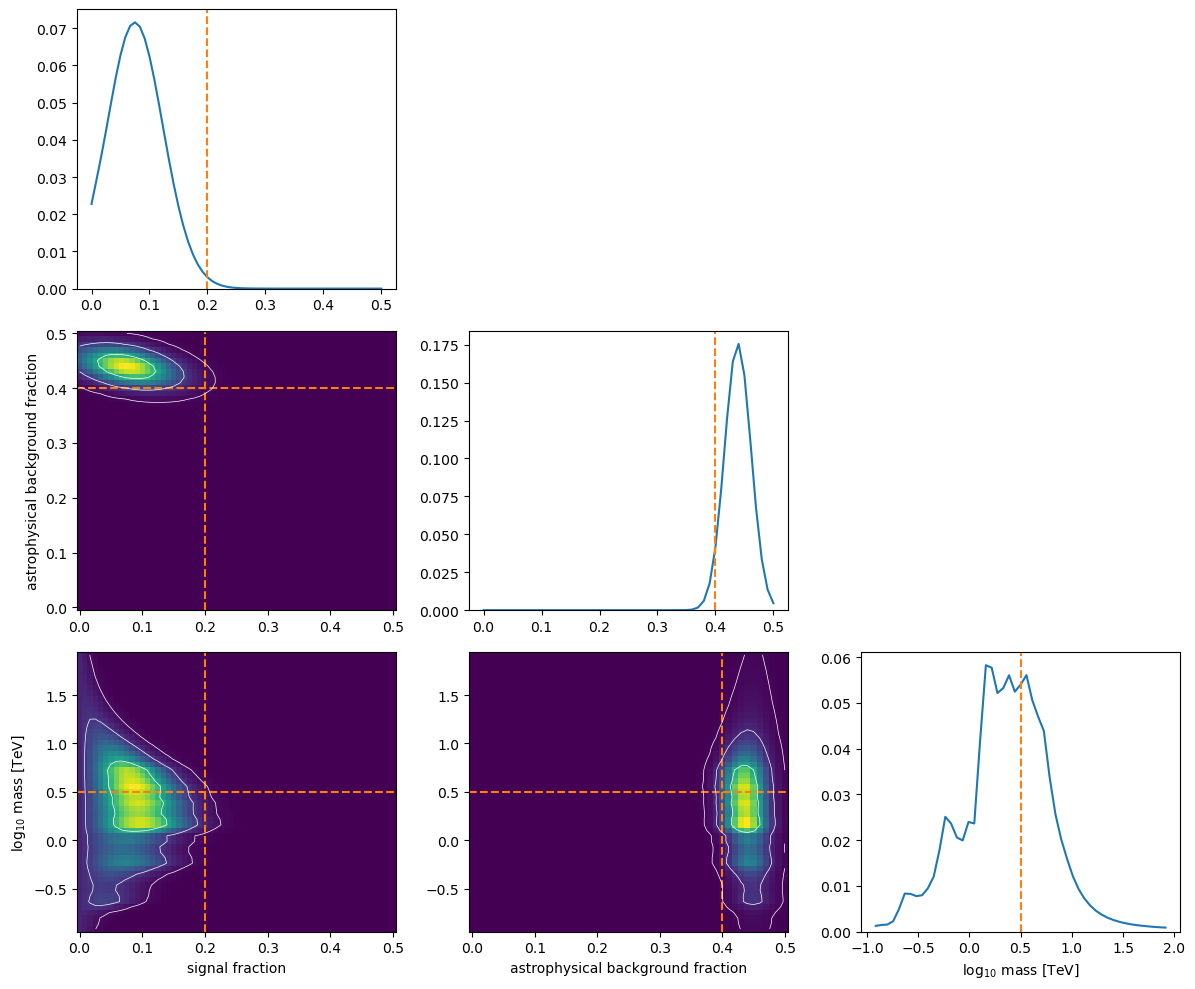

In [26]:
plt.figure(figsize=(12,10))
plt.subplot(331)
plt.plot(sigfracrange, np.exp(special.logsumexp(log_posterior, axis=(1,2)).T))
plt.axvline(truesigfrac, c='tab:orange', ls='--')
plt.ylim([0,None])

plt.subplot(332)
plt.axis('off')



plt.subplot(334)
plt.pcolormesh(sigfracrange, astrofracrange, np.exp(special.logsumexp(log_posterior, axis=2)).T)
plt.axvline(truesigfrac, c='tab:orange', ls='--')
plt.axhline(trueastrofrac, c='tab:orange', ls='--')
plt.ylabel('astrophysical background fraction')


########################################################################################################################
########################################################################################################################
sigfrac_astrofrac_posterior = np.exp(special.logsumexp(log_posterior, axis=2)).T
normed_sigfrac_atrofrac_posterior = sigfrac_astrofrac_posterior/sigfrac_astrofrac_posterior.sum()
n = 100000
t = np.linspace(0, normed_sigfrac_atrofrac_posterior.max(), n)
integral = ((normed_sigfrac_atrofrac_posterior >= t[:, None, None]) * normed_sigfrac_atrofrac_posterior).sum(axis=(1,2))

from scipy import interpolate
f = interpolate.interp1d(integral, t)
t_contours = f(np.array([1-np.exp(-4.5),1-np.exp(-2.0),1-np.exp(-0.5)]))
plt.contour(normed_sigfrac_atrofrac_posterior, t_contours, extent=[sigfracrange[0],sigfracrange[-1], astrofracrange[0],astrofracrange[-1], ], colors='white', linewidths=0.5)
########################################################################################################################
########################################################################################################################


plt.subplot(335)
plt.plot(astrofracrange, np.exp(special.logsumexp(log_posterior, axis=(0,2))).T)
plt.axvline(trueastrofrac, c='tab:orange', ls='--')
plt.ylim([0,None])




plt.subplot(337)

plt.pcolormesh(sigfracrange, logmassrange, np.exp(special.logsumexp(log_posterior, axis=1)).T)
plt.axvline(truesigfrac, c='tab:orange', ls='--')
plt.axhline(truelogmass, c='tab:orange', ls='--')
plt.xlabel('signal fraction')
plt.ylabel(r'log$_{10}$ mass [TeV]')


########################################################################################################################
########################################################################################################################
sigfrac_logmass_posterior = np.exp(special.logsumexp(log_posterior, axis=1)).T
normed_sigfrac_logmass_posterior = sigfrac_logmass_posterior/sigfrac_logmass_posterior.sum()
n = 100000
t = np.linspace(0, normed_sigfrac_logmass_posterior.max(), n)
integral = ((normed_sigfrac_logmass_posterior >= t[:, None, None]) * normed_sigfrac_logmass_posterior).sum(axis=(1,2))

from scipy import interpolate
f = interpolate.interp1d(integral, t)
t_contours = f(np.array([1-np.exp(-4.5),1-np.exp(-2.0),1-np.exp(-0.5)]))
plt.contour(normed_sigfrac_logmass_posterior, t_contours, extent=[sigfracrange[0],sigfracrange[-1], logmassrange[0],logmassrange[-1], ], colors='white', linewidths=0.5)
########################################################################################################################
########################################################################################################################


plt.subplot(338)

plt.pcolormesh(astrofracrange, logmassrange, np.exp(special.logsumexp(log_posterior, axis=0)).T)
plt.axvline(trueastrofrac, c='tab:orange', ls='--')
plt.axhline(truelogmass, c='tab:orange', ls='--')
plt.xlabel('astrophysical background fraction')

########################################################################################################################
########################################################################################################################
astro_logmass_posterior = np.exp(special.logsumexp(log_posterior, axis=0).T)
normed_asotr_logmass_posterior = astro_logmass_posterior/astro_logmass_posterior.sum()
n = 100000
t = np.linspace(0, normed_asotr_logmass_posterior.max(), n)
integral = ((normed_asotr_logmass_posterior >= t[:, None, None]) * normed_asotr_logmass_posterior).sum(axis=(1,2))

from scipy import interpolate
f = interpolate.interp1d(integral, t)
t_contours = f(np.array([1-np.exp(-4.5),1-np.exp(-2.0),1-np.exp(-0.5)]))
plt.contour(normed_asotr_logmass_posterior, t_contours, extent=[astrofracrange[0],astrofracrange[-1], logmassrange[0],logmassrange[-1]], colors='white', linewidths=0.5)
########################################################################################################################
########################################################################################################################

plt.subplot(339)
plt.plot(logmassrange, np.exp(special.logsumexp(log_posterior, axis=(0,1))).T)
plt.axvline(truelogmass, c='tab:orange', ls='--')
plt.xlabel(r'log$_{10}$ mass [TeV]')
plt.ylim([0,None])

plt.tight_layout()
plt.show()

# <h1><b>Plotting

/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_75748/3687004798.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('Blues_r', 4)


IndexError: index 2264 is out of bounds for axis 0 with size 51

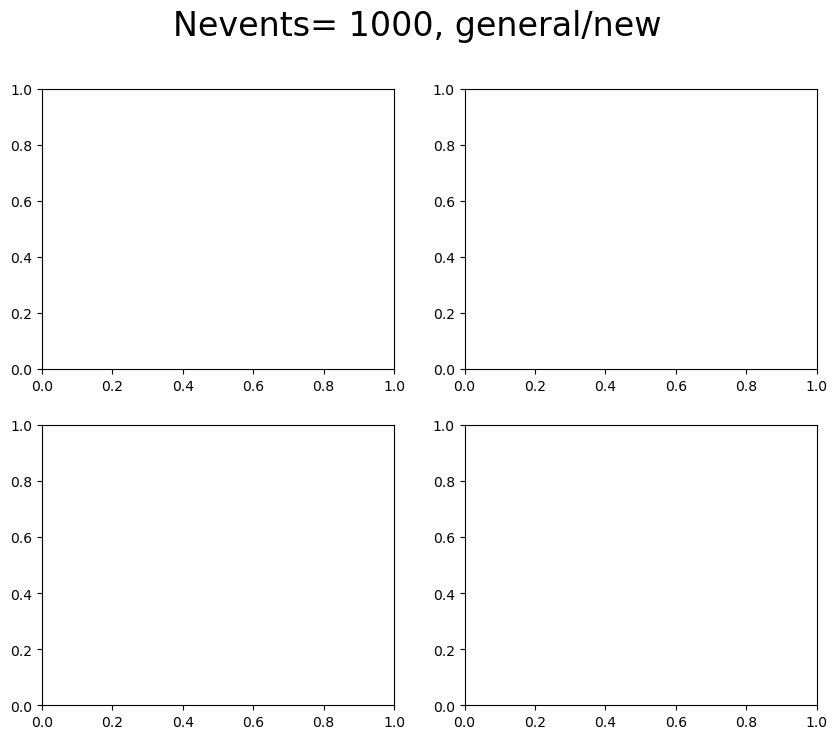

In [27]:
from scipy.stats import norm

import time

colormap = cm.get_cmap('Blues_r', 4)

fig, ax = plt.subplots(2,2, dpi=100, figsize=(10,8))
plt.suptitle(f"Nevents= {Nsamples}, general/new", size=24)

# Upper left plot
logmass_logposterior = special.logsumexp(log_posterior, axis=0)

normalisedlogmassposterior = np.exp(logmass_logposterior-special.logsumexp(logmass_logposterior))

cdflogmassposterior = np.cumsum(normalisedlogmassposterior)
mean = logmassrange[np.abs(norm.cdf(0)-cdflogmassposterior).argmin()]
zscores = [-3, -2,-1,1,2, 3]
logmasspercentiles = []
for zscore in zscores:
    logmasspercentiles.append(logmassrange[np.abs(norm.cdf(zscore)-cdflogmassposterior).argmin()])


ax[0,0].plot(logmassrange,normalisedlogmassposterior, c='tab:green')

ax[0,0].axvline(mean, c='tab:green', ls=':')


for o, percentile in enumerate(logmasspercentiles):
            color = colormap(np.abs(zscores[o])/4-0.01)

            ax[0,0].axvline(percentile, c=color, ls=':')
ax[0,0].axvline(truelogmass, ls='--', color="tab:orange")


if min(mean - logmasspercentiles)>log10eaxistrue[1]-log10eaxistrue[0]:
    for logetrueval in log10eaxistrue:
        ax[0,0].axvline(logetrueval, c='forestgreen', alpha=0.3)
ax[0,0].set_ylim([0, None])
ax[0,0].set_xlim([logmassrange[0], logmassrange[-1]])

# Upper right plot
ax[0,1].axis('off')


# Lower left plot
# ax[1,0].pcolormesh(logmassrange, sigfracrange, np.exp(normalisedlogposterior).T, cmap='Blues')
ax[1,0].pcolormesh(logmassrange, sigfracrange, np.exp(log_posterior), vmin=0)
ax[1,0].axvline(truelogmass, c='tab:orange')
ax[1,0].axhline(truesigfrac, c='tab:orange')
ax[1,0].set_xlabel(r'$log_{10}$ mass [TeV]')
ax[1,0].set_ylabel(r'$\xi$')

ax[1,0].set_ylim([sigfracrange[0], sigfracrange[-1]])
ax[1,0].set_xlim([logmassrange[0], logmassrange[-1]])

########################################################################################################################
########################################################################################################################
# I have no clue how this works but I've checked it against some standard distributions and it seems correct
normed_posterior = np.exp(log_posterior)/np.exp(log_posterior).sum()
n = 100000
t = np.linspace(0, normed_posterior.max(), n)
integral = ((normed_posterior >= t[:, None, None]) * normed_posterior).sum(axis=(1,2))

from scipy import interpolate
f = interpolate.interp1d(integral, t)
t_contours = f(np.array([1-np.exp(-4.5),1-np.exp(-2.0),1-np.exp(-0.5)]))
ax[1,0].contour(normed_posterior, t_contours, extent=[logmassrange[0],logmassrange[-1], sigfracrange[0],sigfracrange[-1]], colors='white', linewidths=0.5)
########################################################################################################################
########################################################################################################################


lambda_logposterior = special.logsumexp(log_posterior, axis=1)

normalisedlambdaposterior = np.exp(lambda_logposterior-special.logsumexp(lambda_logposterior))

cdflambdaposterior = np.cumsum(normalisedlambdaposterior)
meanlambda = sigfracrange[np.abs(norm.cdf(0)-cdflambdaposterior).argmin()]
lambdapercentiles = []
for zscore in zscores:
    lambdapercentile = sigfracrange[np.abs(norm.cdf(zscore)-cdflambdaposterior).argmin()]
    lambdapercentiles.append(lambdapercentile)
    print("l ", np.abs(lambdapercentile - meanlambda), zscore)





ax[1,1].plot(sigfracrange,normalisedlambdaposterior, c='tab:green')

ax[1,1].axvline(meanlambda, c='tab:green', ls=':')


for o, percentile in enumerate(lambdapercentiles):
            color = colormap(np.abs(zscores[o])/4-0.01)

            ax[1,1].axvline(percentile, c=color, ls=':')
ax[1,1].axvline(truesigfrac, ls='--', color="tab:orange")
ax[1,1].set_xlabel(r'$\xi$')
ax[1,1].set_ylim([0, None])


# plt.savefig(time.strftime(f"Figures/TestFigures/{Nsamples}events_lm{truelogmass}_l{truelambda}_%m%d_%H%M.pdf"))
plt.show()

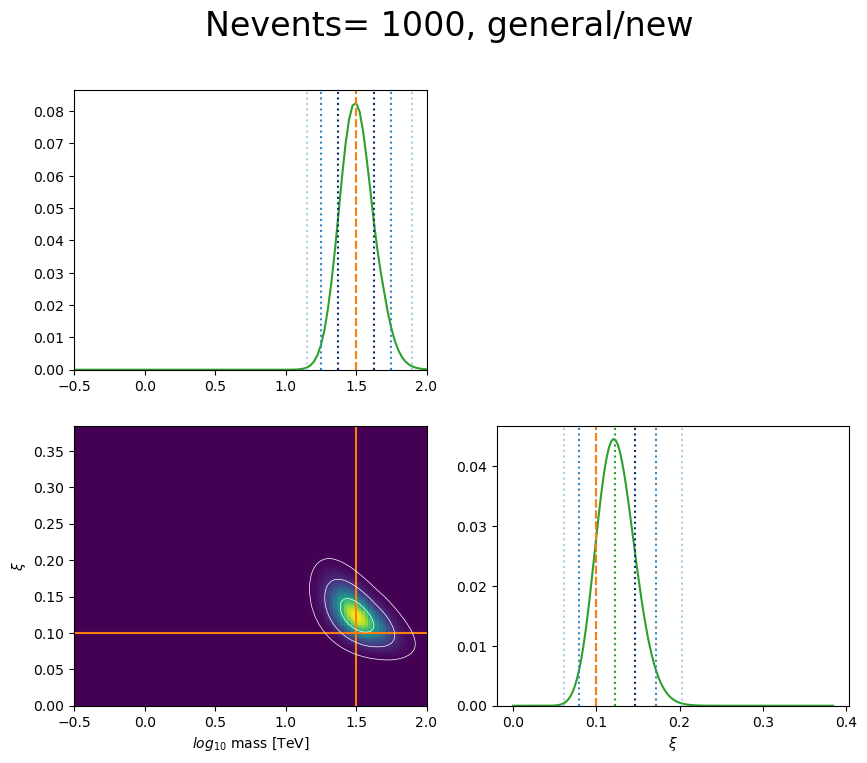

In [ ]:
axis1 = np.linspace(0,1, 11)
axis2 = np.linspace(0,1, 21)

In [ ]:
mesh_axis1, mesh_axis2 = np.meshgrid(axis1, axis2, indexing='ij')

In [ ]:
norm = mesh_axis1+mesh_axis2

mesh_axis1, mesh_axis2 = mesh_axis1/norm, mesh_axis2/norm

In [ ]:
mesh_axis1

array([[       nan, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [1.        , 0.66666667, 0.5       , 0.4       , 0.33333333,
        0.28571429, 0.25      , 0.22222222, 0.2       , 0.18181818,
        0.16666667, 0.15384615, 0.14285714, 0.13333333, 0.125     ,
        0.11764706, 0.11111111, 0.10526316, 0.1       , 0.0952381 ,
        0.09090909],
       [1.        , 0.8       , 0.66666667, 0.57142857, 0.5       ,
        0.44444444, 0.4       , 0.36363636, 0.33333333, 0.30769231,
        0.28571429, 0.26666667, 0.25      , 0.23529412, 0.22222222,
        0.21052632, 0.2       , 0.19047619, 0.18181818, 0.17391304,
        0.16666667],
       [1.        , 0.85714286, 0.75      , 0.66666667, 0.6       ,
        0.54545455, 0.5       , 0.46153846, 0.4285714

In [ ]:
len(np.meshgrid(np.linspace(0,1,11)))

1